
# Risoluzione di Problemi tramite **Ricerca nello Spazio degli Stati**

Questo notebook mostra come modellare problemi come ricerca nello spazio degli stati e risolverli con:
- **BFS**, **DFS (anche con depth-limit)**, **Uniform Cost**, **Greedy Best‑First**, **A\***  
- Un **framework generico** `Problem`/`Node`
- Tre problemi classici:
  1. **8‑Puzzle** (euristiche: tessere fuori posto, distanza di Manhattan)
  2. **Bicchieri d'Acqua** (3L e 5L, obiettivo 4L) — BFS
  3. **Missionari & Cannibali** (3,3) — BFS

Per ogni problema misuriamo **nodi espansi**, **massima frontiera**, **costo**, e tempi.



## Framework Generico (Problem, Node) e Utility
Il problema definisce **stati**, **azioni**, **transizioni**, **costo** e **test di goal**.


In [3]:

from __future__ import annotations
from dataclasses import dataclass
from typing import Any, Iterable, Optional, Tuple, List, Dict, Callable, Set
from collections import deque
import heapq
import time
import math

import matplotlib.pyplot as plt
import pandas as pd
from caas_jupyter_tools import display_dataframe_to_user

@dataclass(frozen=True)
class Node:
    state: Any
    parent: Optional['Node']
    action: Optional[Any]
    path_cost: float = 0.0
    depth: int = 0

    def expand(self, problem: 'Problem') -> Iterable['Node']:
        for a, s2, cost in problem.successors(self.state):
            yield Node(
                state=s2,
                parent=self,
                action=a,
                path_cost=self.path_cost + cost,
                depth=self.depth + 1
            )

def reconstruct_path(n: Optional[Node]) -> List[Any]:
    path = []
    while n is not None:
        path.append(n.state)
        n = n.parent
    path.reverse()
    return path

class Problem:
    def __init__(self, initial: Any, goal: Any | Callable[[Any], bool]):
        self.initial = initial
        self.goal = goal  # state or predicate

    def goal_test(self, state: Any) -> bool:
        if callable(self.goal):
            return bool(self.goal(state))
        return state == self.goal

    # Da sovrascrivere
    def successors(self, state: Any) -> Iterable[Tuple[Any, Any, float]]:
        """Ritorna iterable di (azione, stato_nuovo, costo_azione)."""
        raise NotImplementedError



## Algoritmi di Ricerca (graph-search)
Implementazioni con conteggio **nodi espansi** e **massima frontiera**.


In [4]:

@dataclass
class SearchStats:
    expanded: int
    max_frontier: int
    runtime_s: float
    name: str

@dataclass
class SearchResult:
    path: List[Any]
    cost: float
    stats: SearchStats
    found: bool

def bfs(problem: Problem) -> SearchResult:
    t0 = time.perf_counter()
    frontier = deque([Node(problem.initial, None, None, 0.0, 0)])
    visited: Set[Any] = {problem.initial}
    expanded = 0
    max_frontier = 1

    while frontier:
        max_frontier = max(max_frontier, len(frontier))
        node = frontier.popleft()
        expanded += 1
        if problem.goal_test(node.state):
            t1 = time.perf_counter()
            return SearchResult(reconstruct_path(node), node.path_cost,
                                SearchStats(expanded, max_frontier, t1-t0, "BFS"), True)
        for child in node.expand(problem):
            if child.state not in visited:
                visited.add(child.state)
                frontier.append(child)
    t1 = time.perf_counter()
    return SearchResult([], math.inf, SearchStats(expanded, max_frontier, t1-t0, "BFS"), False)

def dfs(problem: Problem, depth_limit: Optional[int]=None) -> SearchResult:
    t0 = time.perf_counter()
    stack = [Node(problem.initial, None, None, 0.0, 0)]
    visited_path: Set[Any] = set()  # solo per evitare cicli sul path corrente
    expanded = 0
    max_frontier = 1

    while stack:
        max_frontier = max(max_frontier, len(stack))
        node = stack.pop()
        expanded += 1
        if problem.goal_test(node.state):
            t1 = time.perf_counter()
            return SearchResult(reconstruct_path(node), node.path_cost,
                                SearchStats(expanded, max_frontier, t1-t0, "DFS"), True)
        if depth_limit is None or node.depth < depth_limit:
            visited_path.add(node.state)
            # espandiamo e pushiamo LIFO
            succs = list(node.expand(problem))
            for child in reversed(succs):
                if child.state not in visited_path:
                    stack.append(child)
            visited_path.discard(node.state)
    t1 = time.perf_counter()
    return SearchResult([], math.inf, SearchStats(expanded, max_frontier, t1-t0, "DFS"), False)

def uniform_cost_search(problem: Problem) -> SearchResult:
    t0 = time.perf_counter()
    frontier: List[Tuple[float, int, Node]] = []
    counter = 0
    root = Node(problem.initial, None, None, 0.0, 0)
    heapq.heappush(frontier, (0.0, counter, root))
    best_g: Dict[Any, float] = {problem.initial: 0.0}
    expanded = 0
    max_frontier = 1

    while frontier:
        max_frontier = max(max_frontier, len(frontier))
        g, _, node = heapq.heappop(frontier)
        if g > best_g.get(node.state, math.inf):
            continue
        expanded += 1
        if problem.goal_test(node.state):
            t1 = time.perf_counter()
            return SearchResult(reconstruct_path(node), node.path_cost,
                                SearchStats(expanded, max_frontier, t1-t0, "UCS"), True)
        for child in node.expand(problem):
            if child.path_cost < best_g.get(child.state, math.inf):
                best_g[child.state] = child.path_cost
                counter += 1
                heapq.heappush(frontier, (child.path_cost, counter, child))
    t1 = time.perf_counter()
    return SearchResult([], math.inf, SearchStats(expanded, max_frontier, t1-t0, "UCS"), False)

def greedy_best_first(problem: Problem, h: Callable[[Any], float]) -> SearchResult:
    t0 = time.perf_counter()
    frontier: List[Tuple[float, int, Node]] = []
    counter = 0
    root = Node(problem.initial, None, None, 0.0, 0)
    heapq.heappush(frontier, (h(root.state), counter, root))
    visited: Set[Any] = set()
    expanded = 0
    max_frontier = 1

    while frontier:
        max_frontier = max(max_frontier, len(frontier))
        _, _, node = heapq.heappop(frontier)
        if node.state in visited:
            continue
        visited.add(node.state)
        expanded += 1
        if problem.goal_test(node.state):
            t1 = time.perf_counter()
            return SearchResult(reconstruct_path(node), node.path_cost,
                                SearchStats(expanded, max_frontier, t1-t0, "Greedy"), True)
        for child in node.expand(problem):
            if child.state not in visited:
                counter += 1
                heapq.heappush(frontier, (h(child.state), counter, child))
    t1 = time.perf_counter()
    return SearchResult([], math.inf, SearchStats(expanded, max_frontier, t1-t0, "Greedy"), False)

def astar(problem: Problem, h: Callable[[Any], float]) -> SearchResult:
    t0 = time.perf_counter()
    frontier: List[Tuple[float, int, Node]] = []
    counter = 0
    root = Node(problem.initial, None, None, 0.0, 0)
    heapq.heappush(frontier, (h(root.state), counter, root))  # f=g+h; g=0
    best_g: Dict[Any, float] = {problem.initial: 0.0}
    expanded = 0
    max_frontier = 1

    while frontier:
        max_frontier = max(max_frontier, len(frontier))
        f, _, node = heapq.heappop(frontier)
        g = best_g.get(node.state, math.inf)
        if node.path_cost > g:
            continue
        expanded += 1
        if problem.goal_test(node.state):
            t1 = time.perf_counter()
            return SearchResult(reconstruct_path(node), node.path_cost,
                                SearchStats(expanded, max_frontier, t1-t0, "A*"), True)
        for child in node.expand(problem):
            new_g = child.path_cost
            if new_g < best_g.get(child.state, math.inf):
                best_g[child.state] = new_g
                counter += 1
                heapq.heappush(frontier, (new_g + h(child.state), counter, child))
    t1 = time.perf_counter()
    return SearchResult([], math.inf, SearchStats(expanded, max_frontier, t1-t0, "A*"), False)



## Problema 1 — **8‑Puzzle**
Stato come tupla di 9 interi (0 = spazio vuoto). Azioni: sposta vuoto **U/D/L/R**. Costo: 1 per mossa.  
Euristiche:
- `h_misplaced`: tessere fuori posto
- `h_manhattan`: somma delle distanze Manhattan delle tessere (escluso 0)


In [5]:

from typing import Tuple

Board = Tuple[int, ...]  # 9 elementi, 0=blank

class EightPuzzle(Problem):
    GOAL: Board = (1,2,3,4,5,6,7,8,0)

    def __init__(self, initial: Board, goal: Board | Callable[[Board], bool] = GOAL):
        super().__init__(initial, goal)

    @staticmethod
    def _pos(idx: int) -> Tuple[int,int]:
        return divmod(idx, 3)  # (r,c)

    @staticmethod
    def _swap(board: Board, i: int, j: int) -> Board:
        b = list(board)
        b[i], b[j] = b[j], b[i]
        return tuple(b)

    def successors(self, state: Board):
        i0 = state.index(0)
        r, c = self._pos(i0)
        moves = []
        if r > 0: moves.append(('U', i0-3))
        if r < 2: moves.append(('D', i0+3))
        if c > 0: moves.append(('L', i0-1))
        if c < 2: moves.append(('R', i0+1))
        for a, j in moves:
            yield (a, self._swap(state, i0, j), 1.0)

def h_misplaced(s: Board) -> int:
    return sum(1 for i,v in enumerate(s) if v!=0 and v!=EightPuzzle.GOAL[i])

def h_manhattan(s: Board) -> int:
    dist = 0
    for i, v in enumerate(s):
        if v == 0: 
            continue
        r, c = divmod(i, 3)
        gr, gc = divmod(v-1, 3)
        dist += abs(r-gr) + abs(c-gc)
    return dist

def show_board(board: Board, title: str = ""):
    # Figura singola
    fig, ax = plt.subplots(figsize=(3,3))
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 2.5)
    ax.set_xticks(range(3))
    ax.set_yticks(range(3))
    ax.grid(True)
    for i, v in enumerate(board):
        r, c = divmod(i, 3)
        if v != 0:
            ax.text(c, r, str(v), ha='center', va='center', fontsize=14)
    ax.set_title(title)
    plt.show()



### Esecuzione su due istanze (facile e media)



== 8-Puzzle: easy ==


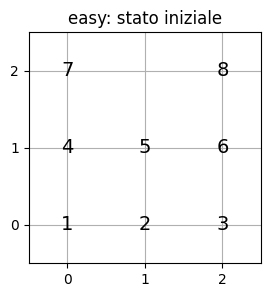

BFS     | found=True | cost=1.0 | expanded=4 | max_frontier=5 | t=0.00007s
Greedy  | found=True | cost=1.0 | expanded=2 | max_frontier=3 | t=0.00005s
A*      | found=True | cost=1.0 | expanded=2 | max_frontier=3 | t=0.00004s
UCS     | found=True | cost=1.0 | expanded=4 | max_frontier=5 | t=0.00005s
## 8-Puzzle — easy


,Algoritmo,Costo,Espansi,Max frontiera,Tempo (s),Lunghezza soluzione
0,BFS,1.0,4,5,0.00007,1
1,Greedy,1.0,2,3,0.00005,1
2,A*,1.0,2,3,0.00004,1
3,UCS,1.0,4,5,0.00005,1



== 8-Puzzle: medium ==


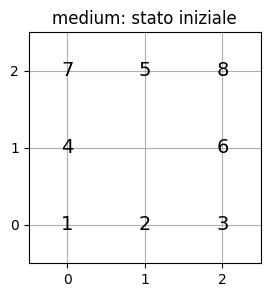

BFS     | found=True | cost=2.0 | expanded=9 | max_frontier=8 | t=0.00014s
Greedy  | found=True | cost=2.0 | expanded=3 | max_frontier=5 | t=0.00008s
A*      | found=True | cost=2.0 | expanded=3 | max_frontier=5 | t=0.00007s
UCS     | found=True | cost=2.0 | expanded=9 | max_frontier=8 | t=0.00012s
## 8-Puzzle — medium


,Algoritmo,Costo,Espansi,Max frontiera,Tempo (s),Lunghezza soluzione
0,BFS,2.0,9,8,0.00014,2
1,Greedy,2.0,3,5,0.00008,2
2,A*,2.0,3,5,0.00007,2
3,UCS,2.0,9,8,0.00012,2


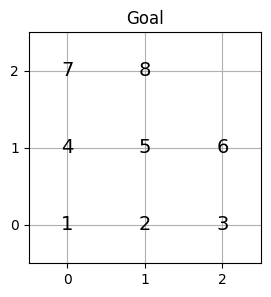

In [6]:

# Istanze
easy = (1,2,3,4,5,6,7,0,8)           # distanza 1
medium = (1,2,3,4,0,6,7,5,8)         # un po' più profonda ma veloce con A*

for name, start in [("easy", easy), ("medium", medium)]:
    P = EightPuzzle(start)
    print(f"\n== 8-Puzzle: {name} ==")
    show_board(start, title=f"{name}: stato iniziale")
    # Eseguiamo vari algoritmi (BFS può esplodere su istanze più dure, qui è ok)
    res_bfs = bfs(P)
    res_greedy_manh = greedy_best_first(P, h_manhattan)
    res_astar_manh = astar(P, h_manhattan)
    res_ucs = uniform_cost_search(P)  # costi uniformi -> ordine per costo

    results = [res_bfs, res_greedy_manh, res_astar_manh, res_ucs]

    rows = []
    for r in results:
        rows.append({
            "Algoritmo": r.stats.name,
            "Costo": r.cost,
            "Espansi": r.stats.expanded,
            "Max frontiera": r.stats.max_frontier,
            "Tempo (s)": round(r.stats.runtime_s, 5),
            "Lunghezza soluzione": len(r.path)-1 if r.found else None
        })
        print(f"{r.stats.name:7s} | found={r.found} | cost={r.cost} | expanded={r.stats.expanded} | max_frontier={r.stats.max_frontier} | t={r.stats.runtime_s:.5f}s")
    df = pd.DataFrame(rows)
    display_dataframe_to_user(f"8-Puzzle — {name}", df)

# Visualizza il goal una volta
show_board(EightPuzzle.GOAL, title="Goal")



## Problema 2 — **Bicchieri d'Acqua** (3L & 5L → ottenere 4L)
Stato `(x,y)` dove `x`=litri nel bicchiere **3L** e `y`=litri nel bicchiere **5L**. Azioni:
- **Riempi** uno dei due
- **Svuota** uno dei due
- **Travaso** da uno all'altro fino a riempire/dismettere

Goal: avere **4L** in uno dei due bicchieri. Usiamo **BFS** (costi uniformi).


In [7]:

from typing import Tuple, Iterable

StateJug = Tuple[int,int]  # (x in 0..3, y in 0..5)

class WaterJug(Problem):
    def __init__(self, initial: StateJug=(0,0), goal: Callable[[StateJug], bool]=lambda s: s[0]==4 or s[1]==4):
        super().__init__(initial, goal)

    def successors(self, s: StateJug) -> Iterable[Tuple[str, StateJug, float]]:
        x, y = s
        succ = []
        # Riempi 3L
        if x < 3: succ.append(("fill3", (3, y), 1.0))
        # Riempi 5L
        if y < 5: succ.append(("fill5", (x, 5), 1.0))
        # Svuota 3L
        if x > 0: succ.append(("empty3", (0, y), 1.0))
        # Svuota 5L
        if y > 0: succ.append(("empty5", (x, 0), 1.0))
        # Versa 3->5
        if x > 0 and y < 5:
            move = min(x, 5-y)
            succ.append(("pour3to5", (x-move, y+move), 1.0))
        # Versa 5->3
        if y > 0 and x < 3:
            move = min(y, 3-x)
            succ.append(("pour5to3", (x+move, y-move), 1.0))
        return succ

def explain_solution(path: List[StateJug], actions: List[str]) -> List[str]:
    steps = []
    for i in range(1, len(path)):
        steps.append(f"{i:02d}. {actions[i-1]} -> stato {path[i]}")
    return steps

# Esecuzione BFS
Pj = WaterJug()
res_j = bfs(Pj)

print("\n== Water Jug (3,5 -> 4) ==")
print(f"found={res_j.found} | cost={res_j.cost} | expanded={res_j.stats.expanded} | max_frontier={res_j.stats.max_frontier} | t={res_j.stats.runtime_s:.5f}s")

# Ricava azioni dalla sequenza di stati
actions = []
if res_j.found and len(res_j.path) > 1:
    # Per recuperare le azioni, rieseguiamo i successori pairwise
    for s_prev, s_next in zip(res_j.path[:-1], res_j.path[1:]):
        for a, s2, _ in WaterJug().successors(s_prev):
            if s2 == s_next:
                actions.append(a)
                break

for line in explain_solution(res_j.path, actions):
    print(line)



== Water Jug (3,5 -> 4) ==
found=True | cost=6.0 | expanded=14 | max_frontier=3 | t=0.00010s
01. fill5 -> stato (0, 5)
02. pour5to3 -> stato (3, 2)
03. empty3 -> stato (0, 2)
04. pour5to3 -> stato (2, 0)
05. fill5 -> stato (2, 5)
06. pour5to3 -> stato (3, 4)



## Problema 3 — **Missionari & Cannibali** (3,3)
Stato `(M_left, C_left, boat_side)` con `boat_side ∈ {0:left, 1:right}`.  
Regole: mai lasciare una sponda con cannibali **>** missionari quando ci sono missionari presenti su quella sponda.
Barca porta **1 o 2** persone a traversata.
Usiamo **BFS** per trovare la soluzione minima in mosse.


In [8]:

from typing import List, Tuple

StateMC = Tuple[int,int,int]  # (M_left, C_left, boat_side: 0=left,1=right)

class MC(Problem):
    def __init__(self, initial: StateMC=(3,3,0), goal: StateMC=(0,0,1)):
        super().__init__(initial, goal)

    @staticmethod
    def _valid(m_left: int, c_left: int) -> bool:
        m_right = 3 - m_left
        c_right = 3 - c_left
        if not (0 <= m_left <= 3 and 0 <= c_left <= 3): return False
        if not (0 <= m_right <= 3 and 0 <= c_right <= 3): return False
        # su ogni sponda: se ci sono missionari, non devono essere superati dai cannibali
        if m_left > 0 and c_left > m_left: return False
        if m_right > 0 and c_right > m_right: return False
        return True

    def successors(self, s: StateMC):
        m_left, c_left, boat = s
        moves = [(1,0),(2,0),(0,1),(0,2),(1,1)]  # (M,C) da spostare
        for dm, dc in moves:
            if boat == 0:
                m2, c2 = m_left - dm, c_left - dc
            else:
                m2, c2 = m_left + dm, c_left + dc
            if self._valid(m2, c2):
                yield ((dm, dc), (m2, c2, 1-boat), 1.0)

# Esecuzione BFS
Pm = MC()
res_m = bfs(Pm)

print("\n== Missionari & Cannibali (3,3) ==")
print(f"found={res_m.found} | cost={res_m.cost} | expanded={res_m.stats.expanded} | max_frontier={res_m.stats.max_frontier} | t={res_m.stats.runtime_s:.5f}s")

# Ricostruzione azioni (come per Water Jug)
actions = []
if res_m.found and len(res_m.path) > 1:
    for s_prev, s_next in zip(res_m.path[:-1], res_m.path[1:]):
        for a, s2, _ in MC().successors(s_prev):
            if s2 == s_next:
                actions.append(a)
                break

for i, (a, st) in enumerate(zip(actions, res_m.path[1:]), start=1):
    print(f"{i:02d}. move {a} -> stato {st}")



== Missionari & Cannibali (3,3) ==
found=True | cost=11.0 | expanded=15 | max_frontier=3 | t=0.00010s
01. move (0, 2) -> stato (3, 1, 1)
02. move (0, 1) -> stato (3, 2, 0)
03. move (0, 2) -> stato (3, 0, 1)
04. move (0, 1) -> stato (3, 1, 0)
05. move (2, 0) -> stato (1, 1, 1)
06. move (1, 1) -> stato (2, 2, 0)
07. move (2, 0) -> stato (0, 2, 1)
08. move (0, 1) -> stato (0, 3, 0)
09. move (0, 2) -> stato (0, 1, 1)
10. move (1, 0) -> stato (1, 1, 0)
11. move (1, 1) -> stato (0, 0, 1)



## Confronto Riepilogativo (8‑Puzzle "medium")
Esempio di tabella per confrontare i metodi su una singola istanza.


In [9]:

P = EightPuzzle((1,2,3,4,0,6,7,5,8))

res = [
    bfs(P),
    uniform_cost_search(P),
    greedy_best_first(P, h_manhattan),
    astar(P, h_manhattan)
]

rows = [{
    "Algoritmo": r.stats.name,
    "Costo": r.cost,
    "Espansi": r.stats.expanded,
    "Max frontiera": r.stats.max_frontier,
    "Tempo (s)": round(r.stats.runtime_s, 5),
    "Lunghezza soluzione": len(r.path)-1 if r.found else None
} for r in res]

df_cmp = pd.DataFrame(rows)
display_dataframe_to_user("Confronto 8-Puzzle — medium", df_cmp)
df_cmp


## Confronto 8-Puzzle — medium


,Algoritmo,Costo,Espansi,Max frontiera,Tempo (s),Lunghezza soluzione
0,BFS,2.0,9,8,0.00011,2
1,UCS,2.0,9,8,0.00010,2
2,Greedy,2.0,3,5,0.00007,2
3,A*,2.0,3,5,0.00004,2


,Algoritmo,Costo,Espansi,Max frontiera,Tempo (s),Lunghezza soluzione
0,BFS,2.0,9,8,0.00011,2
1,UCS,2.0,9,8,0.00010,2
2,Greedy,2.0,3,5,0.00007,2
3,A*,2.0,3,5,0.00004,2
